# Wind Speed Prediction with deeplearning LSTM

## Set Up

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
import sklearn
import sklearn.preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
from numpy import concatenate
import matplotlib as mpl
import os
from sklearn.preprocessing import StandardScaler

### load cleaned data

In [6]:
#read in the data
hourly = pd.read_csv('wind_cleaned_2017_2020.csv',index_col='DATE')

In [7]:
hourly.head()

,wnd_speed,temp_change,hourly_liq_depth_dim,liq_depth_dim,fan_speed,fan_speed2,fan_speed3,rh_air_temp,rel_humiditiy,min_hourly_air_temp,...,min_solar_rad,max_solar_rad,std_solar_rad,surface_temp,std_surface_temp,ex_air_temp,ex_air_temp_2,hourly_gust,wind_std,hour
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,32,44,0,0,1070,944,928,44,403,44,...,0,0,0,44,1,46,44,61,93,0
2017-01-01 01:00:00,25,42,0,0,1068,942,925,42,417,42,...,0,0,0,42,1,44,42,49,82,1
2017-01-01 02:00:00,25,42,0,0,1067,941,925,41,424,40,...,0,0,0,41,0,42,40,53,88,2
2017-01-01 03:00:00,27,39,0,0,1065,940,924,39,428,38,...,0,0,0,39,2,43,38,56,87,3
2017-01-01 04:00:00,30,40,0,0,1064,939,923,40,420,36,...,0,0,0,36,1,41,36,61,89,4


In [8]:
hourly.columns

Index(['wnd_speed', 'temp_change', 'hourly_liq_depth_dim', 'liq_depth_dim',
       'fan_speed', 'fan_speed2', 'fan_speed3', 'rh_air_temp', 'rel_humiditiy',
       'min_hourly_air_temp', 'max_hourly_air_temp', 'std_hourly_air_temp',
       'std_hourly_humidity', 'air_temp', 'air_temp_2', 'air_temp_3',
       'std_hourly_air_temp_2', 'std_hourly_air_temp_3', 'wet1', 'wet2',
       'solar_rad', 'min_solar_rad', 'max_solar_rad', 'std_solar_rad',
       'surface_temp', 'std_surface_temp', 'ex_air_temp', 'ex_air_temp_2',
       'hourly_gust', 'wind_std', 'hour'],
      dtype='object')

## Data Processing

In [9]:
split_fraction = 0.715   #train / validation split
train_split = int(split_fraction * int(hourly.shape[0]))
step = 1   #used if you want to skip hours

learning_rate = 0.001
batch_size = 32
epochs = 10

#normalize the data
def normalize(data, train_split):                 
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [10]:
features = normalize(hourly.values, train_split)  #extract the features normalized
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.870419,-0.504648,-0.068555,-0.066455,2.017964,-0.570617,-1.138990,-1.030727,-1.091170,-0.981134,...,-0.511901,-0.699647,-0.430825,-1.063830,-0.785441,-0.436868,-0.399904,1.335616,-0.036039,-1.661399
1,1.002877,-0.514622,-0.068555,-0.066455,1.998419,-0.625017,-1.169770,-1.051638,-1.024210,-1.002199,...,-0.511901,-0.699647,-0.430825,-1.082647,-0.785441,-0.445051,-0.408097,0.643284,-0.038550,-1.516924
2,1.002877,-0.514622,-0.068555,-0.066455,1.988647,-0.652218,-1.169770,-1.062093,-0.990730,-1.023265,...,-0.511901,-0.699647,-0.430825,-1.092056,-0.993876,-0.453234,-0.416289,0.874062,-0.037180,-1.372450
3,1.250746,-0.529583,-0.068555,-0.066455,1.969103,-0.679418,-1.180029,-1.083003,-0.971598,-1.044330,...,-0.511901,-0.699647,-0.430825,-1.110873,-0.577007,-0.449142,-0.424481,1.047145,-0.037409,-1.227975
4,1.622550,-0.524596,-0.068555,-0.066455,1.959331,-0.706618,-1.190289,-1.072548,-1.009861,-1.065395,...,-0.511901,-0.699647,-0.430825,-1.139099,-0.785441,-0.457325,-0.432674,1.335616,-0.036952,-1.083501


In [11]:
#Recreating the model from https://github.com/balandhanka/Windspeed-Forecasting-LSTM-GRU/blob/master/final_lstm.ipynb

In [12]:
def create_ts_data(dataset, lookback=1, predicted_col=0):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predicted"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [13]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(features, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)','var7(t-1)','var8(t-1)',
                      'var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)',
                      'var17(t-1)','var18(t-1)','var19(t-1)','var20(t-1)','var21(t-1)','var22(t-1)','var23(t-1)','var24(t-1)',
                      'var25(t-1)','var26(t-1)','var27(t-1)','var28(t-1)','var29(t-1)','var30(t-1)','var31(t-1)','var32(t-1)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    1.870419  -0.504648  -0.068555  -0.066455   2.017964  -0.570617   
2    1.002877  -0.514622  -0.068555  -0.066455   1.998419  -0.625017   
3    1.002877  -0.514622  -0.068555  -0.066455   1.988647  -0.652218   
4    1.250746  -0.529583  -0.068555  -0.066455   1.969103  -0.679418   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var23(t-1)  var24(t-1)  \
id                                               ...                           
1   -1.138990  -1.030727  -1.091170   -0.981134  ...   -0.699647   -0.430825   
2   -1.169770  -1.051638  -1.024210   -1.002199  ...   -0.699647   -0.430825   
3   -1.169770  -1.062093  -0.990730   -1.023265  ...   -0.699647   -0.430825   
4   -1.180029  -1.083003  -0.971598   -1.044330  ...   -0.699647   -0.430825   

    var25(t-1)  var26(t-1)  var27(t-1)  var28(t-1)  var29(t-1)  var30(t-1)  \
id      

In [14]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(hourly) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [15]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(24413, 1, 31) (24413,) (10462, 1, 31) (10462,)


## LSTM model for 1 hour 

In [16]:
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=1))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             24576     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 40,145
Trainable params: 40,145
Non-trainable params: 0
_________________________________________________________________


In [143]:
#set an early stopping callback
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


In [144]:
tf.keras.backend.clear_session()

In [145]:
history = model.fit(train_X, train_y, epochs=100,
                    validation_data=(test_X, test_y), batch_size=64, 
                    shuffle=False,callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
382/382 [==============================] - 14s 17ms/step - loss: 0.7956 - val_loss: 0.3747

Epoch 00001: val_loss improved from inf to 0.37466, saving model to model_checkpoint.h5
Epoch 2/100
382/382 [==============================] - 4s 11ms/step - loss: 0.2999 - val_loss: 0.3395

Epoch 00002: val_loss improved from 0.37466 to 0.33953, saving model to model_checkpoint.h5
Epoch 3/100
382/382 [==============================] - 5s 14ms/step - loss: 0.2871 - val_loss: 0.3331

Epoch 00003: val_loss improved from 0.33953 to 0.33306, saving model to model_checkpoint.h5
Epoch 4/100
382/382 [==============================] - 5s 13ms/step - loss: 0.2842 - val_loss: 0.3317

Epoch 00004: val_loss improved from 0.33306 to 0.33168, saving model to model_checkpoint.h5
Epoch 5/100
382/382 [==============================] - 5s 13ms/step - loss: 0.2833 - val_loss: 0.3302

Epoch 00005: val_loss improved from 0.33168 to 0.33016, saving model to model_checkpoint.h5
Epoch 6/100
382/382 [=======

In [146]:
pred_y =  model.predict(test_X)

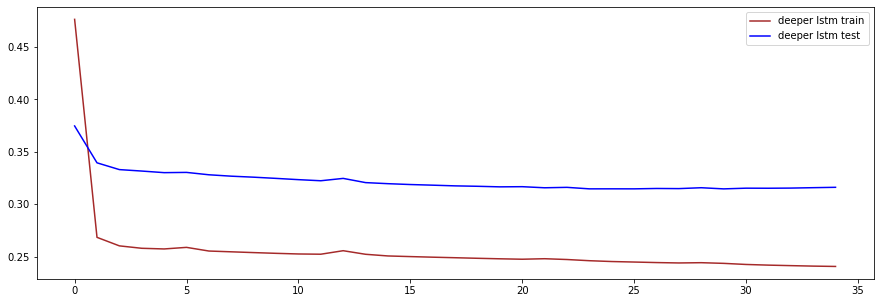

In [147]:
pyplot.plot(history.history['loss'], label='deeper lstm train', color='brown')
pyplot.plot(history.history['val_loss'], label='deeper lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [148]:
test_y.reshape(10462,1)

array([[-0.85614005],
       [-0.85614005],
       [-0.98007454],
       ...,
       [-0.48433656],
       [-0.60827106],
       [-0.73220555]])

### Persistent model numbers for comparison

In [149]:
from sklearn.metrics import *
from math import sqrt
test_y_persist=test_y[:-6]
pred_y_persist=test_y[6:]
MSE = mean_squared_error(test_y_persist, pred_y_persist)
R2 = r2_score(test_y_persist, pred_y_persist)
RMSE = sqrt(mean_squared_error(test_y_persist, pred_y_persist))
MAE = mean_absolute_error(test_y_persist, pred_y_persist)
print(f'persistent model MSE {MSE}')
print(f'persistent model R2 {R2}')
print(f'persistent model RMSE {RMSE}')
print(f'persistent model MAE {MAE}')

persistent model MSE 1.2009962513334058
persistent model R2 -0.04129338603384225
persistent model RMSE 1.095899745110567
persistent model MAE 0.8083478100644846


### graphs

0.3130493153248531
0.7284562728995325
0.5595081012146769
0.4033790680091858


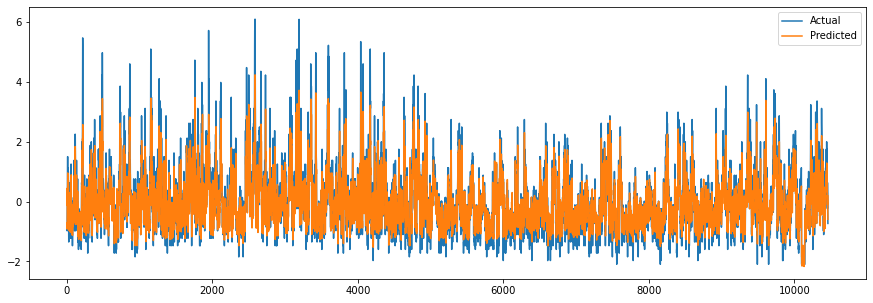

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(f'LSTM model MSE {MSE}')
print(f'LSTM model R2 {R2}')
print(f'LSTM model RMSE {RMSE}')
print(f'LSTM model MAE {MAE}')

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

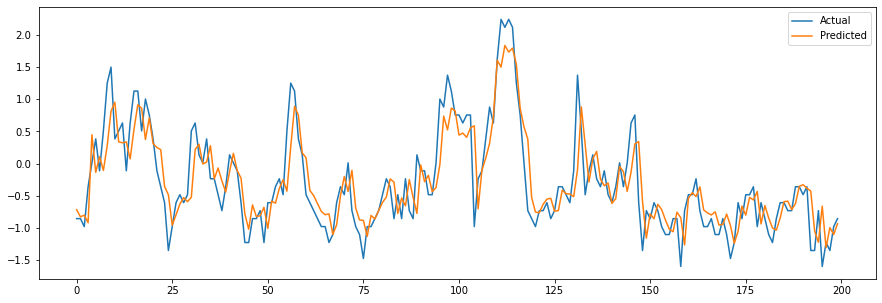

In [20]:
#over small part of data
plt.plot(test_y[0:200], label = 'Actual')
plt.plot(pred_y[0:200], label = 'Predicted')
plt.legend()
plt.show()

In [21]:
#Un-normalizing the data
test_y_unnorm = test_y * hourly['wnd_speed'].std() + hourly['wnd_speed'].mean()
pred_y_unnorm = pred_y * hourly['wnd_speed'].std() + hourly['wnd_speed'].mean()

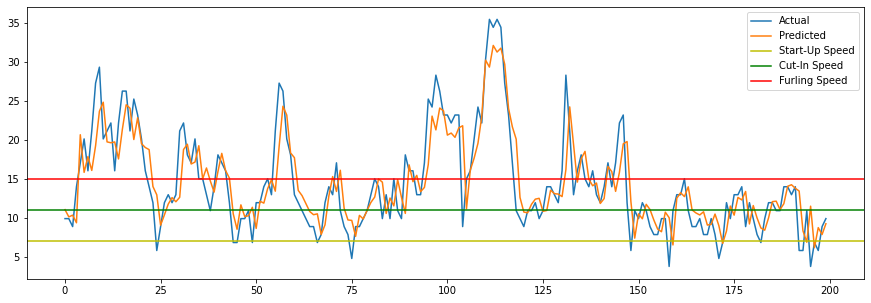

In [22]:
plt.plot(test_y_unnorm[0:200], label = 'Actual')
plt.plot(pred_y_unnorm[0:200], label = 'Predicted')
plt.axhline(y = 7, label = 'Start-Up Speed',color='y')
plt.axhline(y = 11, label = 'Cut-In Speed',color='g')
plt.axhline(y = 15, label = 'Furling Speed',color = 'r')
plt.legend()
plt.show()

## Deploying model

In [23]:
model_version = "0001"
model_name = "wind_speed_predictor"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: wind_speed_predictor\0001\assets


INFO:tensorflow:Assets written to: wind_speed_predictor\0001\assets


In [24]:
project_id = "nimble-yen-312518"

In [25]:
import googleapiclient.discovery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "nimble-yen-312518-3eb8917d0b33.json"
model_id = "wind_speed_predictor"
model_path = "projects/{}/models/{}".format(project_id, model_id)
model_path += "/versions/wind_speed_v0001/" # if you want to run a specific version
ml_resource = googleapiclient.discovery.build("ml", "v1").projects()

ModuleNotFoundError: No module named 'googleapiclient'

In [ ]:
def predict(X):
    input_data_json = {"signature_name": "serving_default",
                       "instances": X.tolist()}
    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return np.array([pred['dense'] for pred in response["predictions"]])

In [26]:
Y_probas = predict(test_X[0:100])
np.round(Y_probas, 2)

NameError: name 'predict' is not defined

## Multi Hour Prediction Model

In [27]:
dataset = features.values
scaler = StandardScaler().fit(dataset[:train_split])
dataset = scaler.transform(dataset)

In [28]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [29]:
past_history = 100
future_target = 6
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             train_split, None, past_history,
                                             future_target, STEP)

In [30]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

In [32]:
modelMulti = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True,
                         input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, dropout=0.2),
    
    tf.keras.layers.Dense(6),
])


modelMulti.compile(
    optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [33]:
earlyMulti = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

historyMulti = modelMulti.fit(train_data_multi, epochs=100,
                    validation_data=val_data_multi,
                    callbacks=[earlyMulti])

Epoch 1/100
98/98 [==============================] - 28s 249ms/step - loss: 0.9807 - val_loss: 0.0254
Epoch 2/100
98/98 [==============================] - 24s 246ms/step - loss: 0.8156 - val_loss: 0.0223
Epoch 3/100
98/98 [==============================] - 24s 244ms/step - loss: 0.9133 - val_loss: 0.0158
Epoch 4/100
98/98 [==============================] - 24s 242ms/step - loss: 0.7308 - val_loss: 0.0150
Epoch 5/100
98/98 [==============================] - 24s 245ms/step - loss: 0.9891 - val_loss: 0.0135
Epoch 6/100
98/98 [==============================] - 24s 240ms/step - loss: 0.6423 - val_loss: 0.0149
Epoch 7/100
98/98 [==============================] - 24s 244ms/step - loss: 0.6819 - val_loss: 0.0119
Epoch 8/100
98/98 [==============================] - 25s 252ms/step - loss: 0.7665 - val_loss: 0.0131
Epoch 9/100
98/98 [==============================] - 25s 252ms/step - loss: 0.5550 - val_loss: 0.0113
Epoch 10/100
98/98 [==============================] - 25s 256ms/step - loss: 0.677

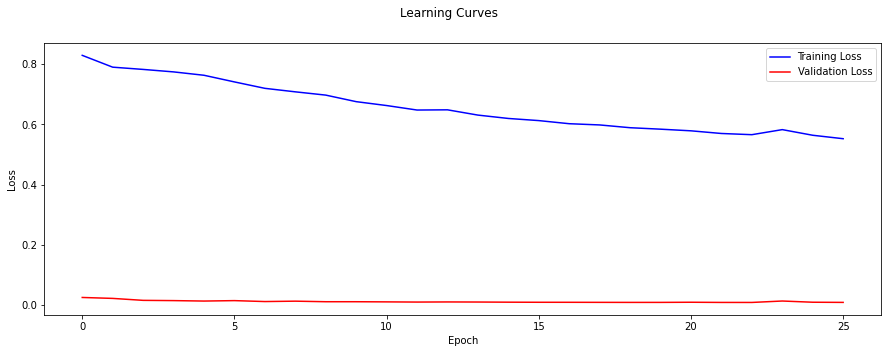

In [34]:
history_df = pd.DataFrame(historyMulti.history)
history_df['epoch'] = historyMulti.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### graphs

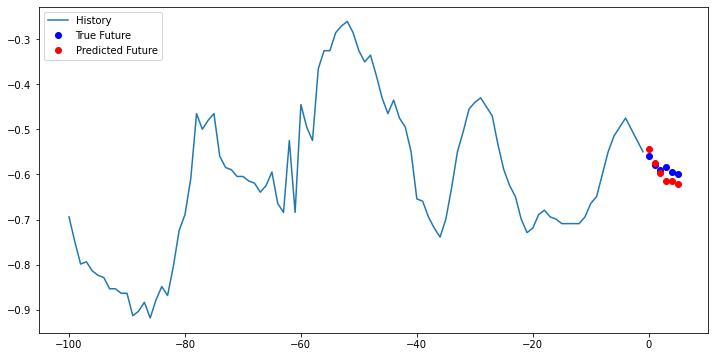

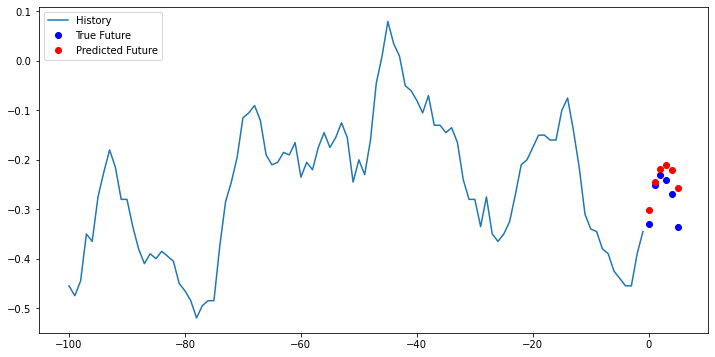

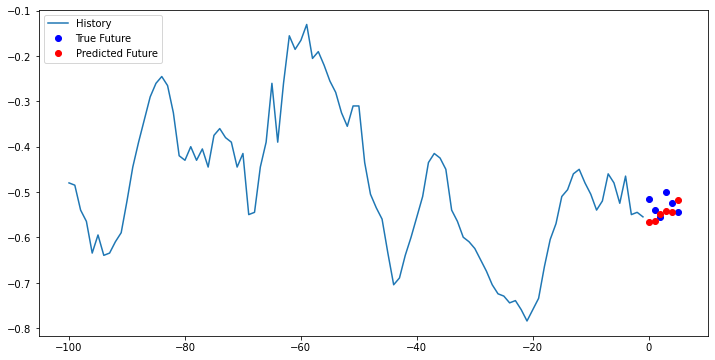

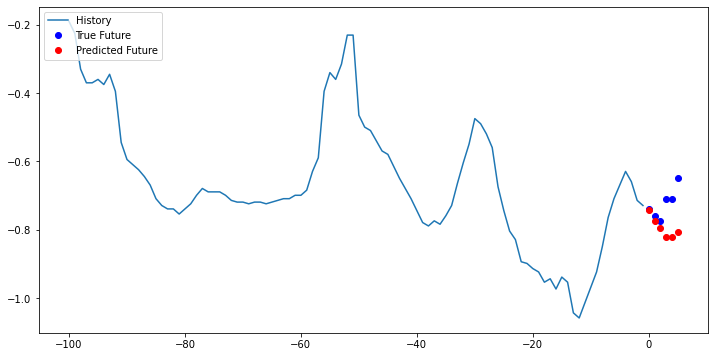

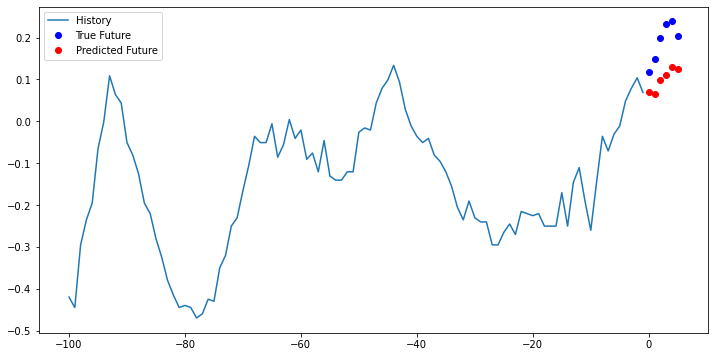

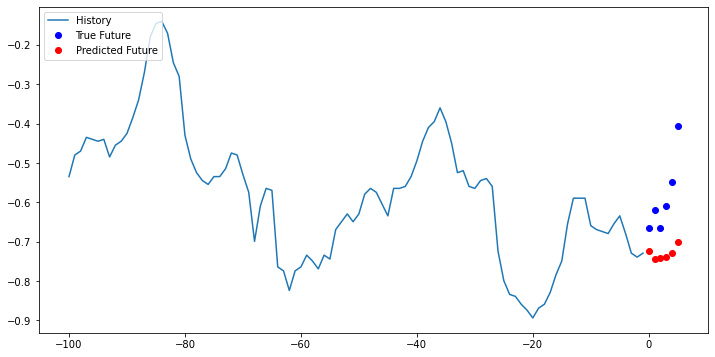

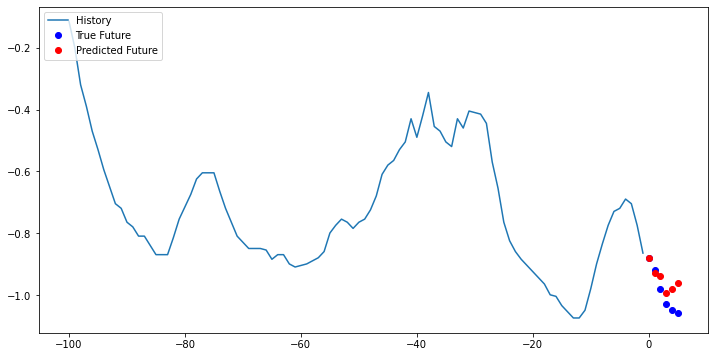

In [35]:
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
for x, y in val_data_multi.take(7):
    multi_step_plot(x[0], y[0], modelMulti.predict(x)[0])

In [46]:
predictions=modelMulti.predict(val_data_multi)

In [88]:
predictions.shape

(9834, 6)

In [59]:
length=len(list(val_data_multi.unbatch().as_numpy_iterator()))

In [68]:
yvalues=list(val_data_multi.unbatch().as_numpy_iterator())[:][:][1]

In [84]:
y_values=[]
for x in list(val_data_multi.unbatch().as_numpy_iterator()):
    y_values.append(x[1])

In [99]:
np.transpose(y_values)

(6, 9834)

In [98]:
predictions.T.shape

(6, 9834)

### Metrics

In [129]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

for t in range(6):
    temp_y=np.transpose(y_values)[t]
    temp_p=predictions.T[t]
    MSE = mean_squared_error(temp_y, temp_p)
    R2 = r2_score(temp_y, temp_p)
    RMSE = sqrt(mean_squared_error(temp_y, temp_p))
    MAE = mean_absolute_error(temp_y, temp_p)

    print(f' the MSE for {t+1} hours in the future is {MSE}')
    #print(R2)
    #print(RMSE)
    #print(MAE)


 the MSE for 1 hours in the future is 0.004097785755825957
 the MSE for 2 hours in the future is 0.005444622975399891
 the MSE for 3 hours in the future is 0.00772506228887881
 the MSE for 4 hours in the future is 0.010040809607147856
 the MSE for 5 hours in the future is 0.012213256321181672
 the MSE for 6 hours in the future is 0.014785846071394534


### Persistent metrics

In [126]:
persistent_pred=np.transpose(y_values)[0][:-6]

In [128]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

for t in range(6):
    temp_y=np.transpose(y_values)[t][1:-5]
    temp_p=persistent_pred
    MSE = mean_squared_error(temp_y, temp_p)
    R2 = r2_score(temp_y, temp_p)
    RMSE = sqrt(mean_squared_error(temp_y, temp_p))
    MAE = mean_absolute_error(temp_y, temp_p)

    print(f' the MSE for {t+1} hours in the future is {MSE}')
    #print(R2)
    #print(RMSE)
    #print(MAE)


 the MSE for 1 hours in the future is 0.0024584141232643166
 the MSE for 2 hours in the future is 0.006664944826169482
 the MSE for 3 hours in the future is 0.012307676518054554
 the MSE for 4 hours in the future is 0.01885990305641931
 the MSE for 5 hours in the future is 0.025801345895715335
 the MSE for 6 hours in the future is 0.03271950008353599
